### features:
* spectogram coef
* zero crossing rate
* selected chromogram values
* selected tempogram values
* wavelet levels

In [1]:
import pandas as pd 
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import auc
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, recall_score
import matplotlib.pyplot as plt
import itertools

RuntimeError: module compiled against API version 0xe but this version of numpy is 0xd

In [2]:
path = "/Users/ecem/Desktop/phonocardiogram/data/MV"

## Load data

Here, our target is to predict disease of patients with multiple diseases. So; our y will be disease column of two column indicatin geach patients disease.

In [3]:
present_df = pd.read_csv(path + "/present/present_MV_p_features.csv", index_col = 0) #1080, 18657
#present_df

In [4]:
absent_df = pd.read_csv(path + "/absent/absent_MV_p_features.csv", index_col = 0) #5534, 18657
#absent_df

### create labels

In [5]:
y = np.concatenate((np.ones(1080), np.zeros(5534)), axis =0)
y.shape

(6614,)

## concat features

In [6]:
df = pd.concat([present_df, absent_df], axis = 0) #6614, 18657
#df

## With threshold

In [7]:
from sklearn.feature_selection import VarianceThreshold
vt = VarianceThreshold(threshold =  0.001)   # düşük  threshold
_ = vt.fit(df)
masked = vt.get_support()
features_masked = df.loc[:, masked]
#features_masked # uncomment to see the dataframe #6614, 432

In [8]:
X_train_, X_valid_, y_train_, y_valid_ = train_test_split(features_masked, y, train_size=0.8, test_size=0.2,
                                                                random_state=42)

In [9]:
import xgboost as xgb

clf = xgb.XGBClassifier(objective= "binary:logistic", eval_metric = "logloss")


In [10]:
clf.fit(X_train_, y_train_)


XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric='logloss', gamma=0, gpu_id=-1,
              grow_policy='depthwise', importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_bin=256, max_cat_to_onehot=4, max_delta_step=0, max_depth=6,
              max_leaves=0, min_child_weight=1, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=0,
              num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [11]:
yhat = clf.predict(X_valid_)

In [12]:
yhat.shape

(1323,)

In [13]:
y_valid_.shape

(1323,)

In [14]:
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_valid_, yhat)
print("accuracy: %.2f%%" % (accuracy * 100.0))

accuracy: 85.26%


In [15]:
from sklearn.metrics import recall_score
recall = recall_score(y_valid_, yhat, average= 'weighted')
print("recall: %.2f%%" % (recall * 100.0))


recall: 85.26%


In [16]:
from sklearn.metrics import precision_score
precision = precision_score(y_valid_, yhat, average= 'weighted')
print("precision: %.2f%%" % (precision * 100.0))

precision: 85.67%


/Users/ecem/miniforge3/envs/tf-metal/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


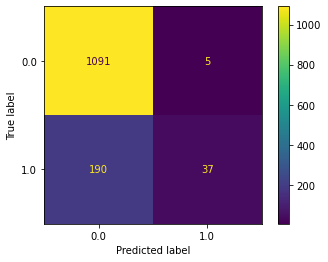

In [17]:
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(clf, X_valid_, y_valid_) 

In [18]:
from sklearn.metrics import roc_auc_score
score = roc_auc_score(y_valid_, yhat)
print(f"ROC AUC: {score:.4f}")

ROC AUC: 0.5792


In [19]:
names =["absent", "present"]
print(classification_report(y_valid_, yhat, target_names = names))

              precision    recall  f1-score   support

      absent       0.85      1.00      0.92      1096
     present       0.88      0.16      0.28       227

    accuracy                           0.85      1323
   macro avg       0.87      0.58      0.60      1323
weighted avg       0.86      0.85      0.81      1323



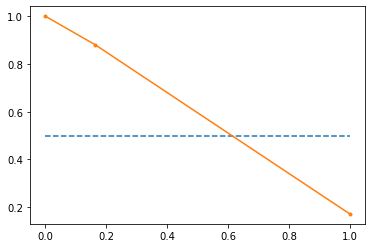

AUC: 0.594


In [20]:
precision, recall, thresholds = precision_recall_curve(y_valid_, yhat)
auc_score = auc(recall, precision)
plt.plot([0, 1], [0.5, 0.5], linestyle='--')
plt.plot(recall, precision, marker='.')
plt.show()
print('AUC: %.3f' % auc_score)